# Regression Test Case Selection Using Machine Learning

# Introduction

**Abstract** : 

Regression testing is the common task of retesting software that has been changed or extended by new features during software development and most of the time retesting the whole program is not feasible with reasonable time and cost, and to overcome only a subset of all test cases is executed for regression testing, e.g., by executing test cases according to test case prioritization.

There are a vast amount of methods for test case selection exist but mostly it is a based on domain expertise of Test Engineers/Subject Matter Expert.As obvious, this manual process is time consuming, iterative and largely depends upon the engineer's skills which mean there are high chances of missing some relevant test cases.

**Propsed Solution** : 

In this Proof of Concept (POC), we will select test cases for manual regression testing with the help of Classification Learning Model.

Our approach considers meta data related to test cases and Natural Language test case descriptions as an input to classification learning models to predict selection of test cases. 

Below image will summarize the proposed solution

<img src="images/PropsedSolution.png">

# Data Collection and Preparation

For POC we have considered microservices Test cases across four release cycles as our Test Data.

This is an authorization microservice it is based on Oauth2 standard which is widely used in industry for authorization across systems/microservices. Refer this [link](https://oauth.net/about/introduction/) for more information on Oauth2


Before going forward let's understand how currently test selection process is happening in HP Cloud Print Platform

<img src="images/TCSelectionProcess.png">

                                              
> **Release Manifest:** It is collection of versioned stuff that is being deployed, configuration settings, and issues/stories/artifacts description which are going to be deployed in particular release

> **JIRA:** Agile Project Management and Bug Tracking Tool

> **Service Functionality Mapping File:** Matrix which consists of mapping between Microservices and functionality , this will help users to understand impacted area when particular microservice getting affected

> **Test Rail:** Test Management Tool

Let's understand the process step by step

**Step 1:** For every release Subject Matter Expert(**SME**) refer Release Manifest to understand which microservices are under test and details of the fixes/commits in that particular release 

**Step 2:** SME will take stories and Bug ID's from Release Manifest and navigate to JIRA to get more relevant details , also based on the domain knowledge SME will refer Service Functionality Mapping File to understand impacted functionality

**Step 3:** Based on the information from JIRA ,SME will again refer Service Functionality Mapping File to get the list of impacted fucntionality

**Step 4:** Based on the impacted functionality list from above two steps SME will now navigate to Test Rail to search relevant test cases

**Step 5:** With the help of domain knowledge and data collected from above steps SME will select the list of test cases from Test Rail

Let's take a quick look at test data which consists of regression test cases across four release cycles

> **Note : Dataset is not present in the GIT repository as it was internal to organization. Please use this notebook for reference purpose and generate your own data**

In [205]:
#importing required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
#Creating function to print in bold
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [206]:
#Importing test case dump
dataset=pd.read_csv("TestCases_TestData.csv")

In [207]:
#Checking the number of records and columns
dataset.shape

(664, 12)

In [208]:
#Checking data set
dataset.head()

,Id,ReleaseID,Type of Test Case,TestCaseTitle,TestCaseDescription,Error Prone Test Cases,Automation Status,Any Defect,JIRA Bug ID,Bug Description,GIT Commit Message,Target
0,1,R20.2.1,Sanity,Get the short and detailed health status APIs,When I call short health status API\nThen Resp...,No,Yes,Yes,WPPX1-949,AMI Refresh for RAW services,Fix for WPPX1-946 AMI refresh,1
1,2,R20.2.1,Sanity,Get the AuthZ service metadata,When I call metadata data API\nThen Response s...,No,Yes,Yes,WPPX1-949,AMI Refresh for RAW services,Fix for WPPX1-946 AMI refresh\nOpenId Metadata...,1
2,3,R20.2.1,Sanity,Get the public keys for validating token,When I call GET Json web keys discovery API\r\...,No,Yes,Yes,WPPX1-949,AMI Refresh for RAW services,Fix for WPPX1-946 AMI refresh,1
3,4,R20.2.1,API/Functionality,Verify Client delegation API: Exchange Access ...,Given I have a valid access token generated ...,Yes,Yes,No,NaN,NaN,NaN,1
4,5,R20.2.1,API/Functionality,Verify Client delegation API:Exchange Access t...,Given I have a valid access token generated fr...,No,Yes,No,NaN,NaN,NaN,1


Let's understand the columns/features present in dataset

<a>**ID**</a>: Unique Identifier of Records

<a>**ReleaseID**</a> : Release Identification number , Ex: **R20.2.1** stands for 'First release of 2 month of Year 2020

<a>**Type of Test Case**</a> : Cateogarization of Test cases , Ex: 'Sanity' test cases are supposed to be executed for Sanity of microservice and 'API/Functionality' test cases are for core functionality of microservice

<a>**TestCaseTitle**</a> : Title or summary of test case
    
<a>**TestCaseDescription**</a> : Steps for a test cases in Behavior Driven Devlopment(BDD) format

<a>**Error Prone Test Cases**</a> : Test cases which are covering high error prone area , these test cases must be executed in every release

<a>**Automation Status**</a> : Wheather test case is automated or not

<a>**Any Defect**</a> : If there is any defect in the release manifest then it will be mapped to the corresponding/relevant test cases and this column will be marked as 'Yes'

<a>**JIRA Bug ID**</a> : Corresponding Bug ID of JIRA

<a>**Bug Description**</a> : JIRA Title/description of corresponding bug

<a>**GIT Commit Message**</a> : For particular release , if there are any commits in GIT then the corresponding/relevant test cases and this column will be marked with commit messages

<a>**Target**</a> : Binary classification of Test Cases selection

> **It's quite possible that in actual , SME/Test Engineer is not considering above features/columns for test cases selection. But we strongly believe that these features should be considered during test case selection as they are directly or indirectly impacting Release and Qualification Cycles**

**Exploratory Data Analysis**:

Let's explore these features one by one and it's impact on target variable , in other words let's try to understand how these features are related to selection of test cases. This analalysis will eventually help us in training our classifier model.


Let's start with **Categorical Variables** ,will begin with **ReleaseID**.

We will check that how test cases are selected across different releases

In [209]:
#Getting unique value of releaseID column
dataset['ReleaseID'].unique()

array(['R20.2.1', 'R20.1.2', 'R20.1.1', 'R19.12.1'], dtype=object)

In [210]:
#Getting unique count for each release
dataset['ReleaseID'].value_counts()

R20.1.1     166
R19.12.1    166
R20.2.1     166
R20.1.2     166
Name: ReleaseID, dtype: int64

Test data comprise of four different releases and for each release there are equal number of test cases , but not all of them are selected for execution.

Let's visualize that how many test cases selection is happening across release

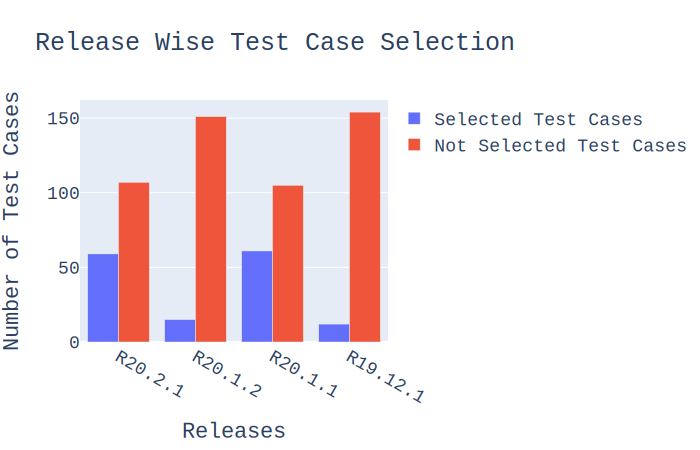

In [211]:
#Creating Dictonary for Release ID and selected and not selected test cases
selectedTCRelease_dict={'R20.2.1':(len(dataset[(dataset['ReleaseID'] == 'R20.2.1') & (dataset['Target'] == 1)].index)),
                        'R20.1.2':(len(dataset[(dataset['ReleaseID'] == 'R20.1.2') & (dataset['Target'] == 1)].index)),
                        'R20.1.1':(len(dataset[(dataset['ReleaseID'] == 'R20.1.1') & (dataset['Target'] == 1)].index)),
                        'R19.12.1':(len(dataset[(dataset['ReleaseID'] == 'R19.12.1') & (dataset['Target'] == 1)].index))}
nonselectedTCRelease_dict={'R20.2.1':(len(dataset[(dataset['ReleaseID'] == 'R20.2.1') & (dataset['Target'] == 0)].index)),
                           'R20.1.2':(len(dataset[(dataset['ReleaseID'] == 'R20.1.2') & (dataset['Target'] == 0)].index)),
                           'R20.1.1':(len(dataset[(dataset['ReleaseID'] == 'R20.1.1') & (dataset['Target'] == 0)].index)),
                           'R19.12.1':(len(dataset[(dataset['ReleaseID'] == 'R19.12.1') & (dataset['Target'] == 0)].index))}

#Converting Data Dictonary to series
selectedTCRelease_series=pd.Series(selectedTCRelease_dict)
nonselectedTCRelease_series=pd.Series(nonselectedTCRelease_dict)

#Visualizing selecting test cases per Release
fig = go.Figure(data=[
    go.Bar(name='Selected Test Cases', x=selectedTCRelease_series.index, y=selectedTCRelease_series.values),
    go.Bar(name='Not Selected Test Cases',  x=nonselectedTCRelease_series.index, y=nonselectedTCRelease_series.values)
])
# Change the bar mode
fig.update_layout(
    title="Release Wise Test Case Selection",
    xaxis_title="Releases",
    yaxis_title="Number of Test Cases",
    barmode='group',
    font=dict(
        family="Courier New, monospace",
        size=18,
    )
)
fig.update_layout()
fig.show("svg")

It's evident that selection of test cases is not uniform across the release and which is obvious , but we need to identify that what are the fetaures which play role in test case selection.

Let's see how defects are mapped across releases

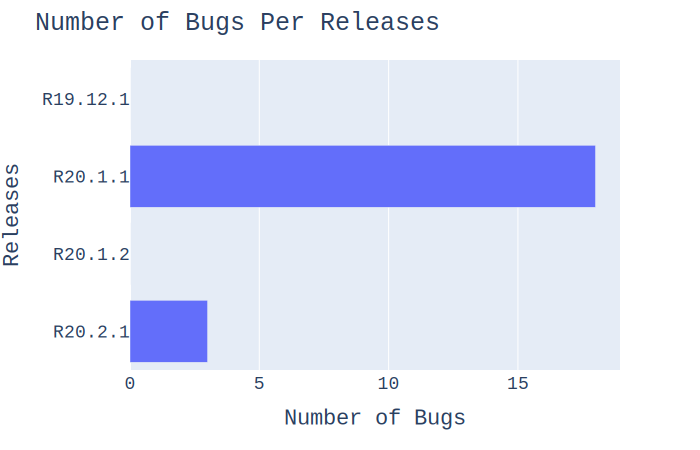

In [212]:
#Creating Dictonary for Release ID and bugs in that particular Release
bugsInrelease_dict={'R20.2.1':(len(dataset[(dataset['ReleaseID'] == 'R20.2.1') & (dataset['Any Defect'] == 'Yes')].index)),
                        'R20.1.2':(len(dataset[(dataset['ReleaseID'] == 'R20.1.2') & (dataset['Any Defect'] == 'Yes')].index)),
                        'R20.1.1':(len(dataset[(dataset['ReleaseID'] == 'R20.1.1') & (dataset['Any Defect'] == 'Yes')].index)),
                        'R19.12.1':(len(dataset[(dataset['ReleaseID'] == 'R19.12.1') & (dataset['Any Defect'] == 'Yes')].index))}
#Converting Data Dictionary into Series
bugsInrelease_series=pd.Series(bugsInrelease_dict)
#Visualizing Bugs per releases
fig = px.bar(bugsInrelease_series, x=bugsInrelease_series.values, y=bugsInrelease_series.index,orientation='h')
# Change the bar mode
fig.update_layout(
    title="Number of Bugs Per Releases",
    xaxis_title="Number of Bugs",
    yaxis_title="Releases",   
    font=dict(
        family="Courier New, monospace",
        size=18,
    )
)
fig.update_layout()
fig.show("svg")


In R20.1.1 release there are **18** bugs and in R20.2.1 release there are **3** bugs , from the previous graph we can say that maximum number of selected test cases are in these two releases only . 

With this analysis we can say that **Any Defect** feature is playing role in selection of test case.

Now let's start exploring column **Error Prone Test Cases** 

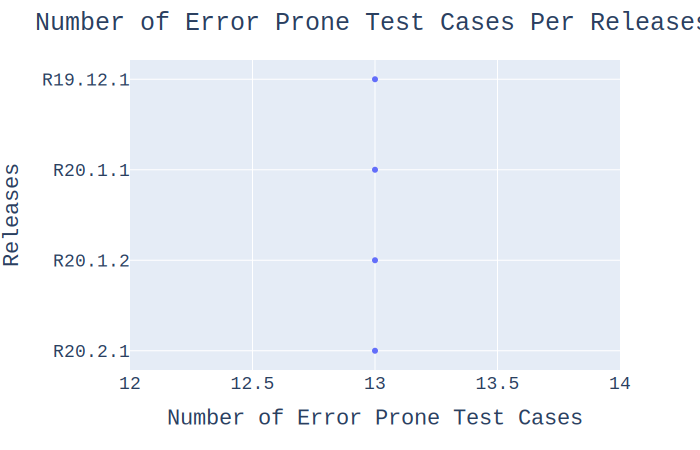

In [213]:
#Creating Dictonary for Error Prone in that particular Release
errorproneTestCase_dict={'R20.2.1':(len(dataset[(dataset['ReleaseID'] == 'R20.2.1') & (dataset['Error Prone Test Cases'] == 'Yes')].index)),
                        'R20.1.2':(len(dataset[(dataset['ReleaseID'] == 'R20.1.2') & (dataset['Error Prone Test Cases'] == 'Yes')].index)),
                        'R20.1.1':(len(dataset[(dataset['ReleaseID'] == 'R20.1.1') & (dataset['Error Prone Test Cases'] == 'Yes')].index)),
                        'R19.12.1':(len(dataset[(dataset['ReleaseID'] == 'R19.12.1') & (dataset['Error Prone Test Cases'] == 'Yes')].index))}
#Converting Data Dictionary into Series
errorproneTestCase_series=pd.Series(errorproneTestCase_dict)
#Visualizing Bugs per releases
fig = px.scatter(errorproneTestCase_series, x=errorproneTestCase_series.values, y=errorproneTestCase_series.index)
# Change the bar mode
fig.update_layout(
    title="Number of Error Prone Test Cases Per Releases",
    xaxis_title="Number of Error Prone Test Cases",
    yaxis_title="Releases",   
    font=dict(
        family="Courier New, monospace",
        size=18,
    )
)
fig.update_layout()
fig.show("svg")

Number of Error Prone Test Cases is same in all release , on closer look it seems to be obvious because every release have similar set of test cases and these cases will be marked as 'Error Prone' based on domain expertise of SME.

Let's see how these test cases are selected

In [214]:
printmd('**Number of Not Selected Error Prone Test Cases are {}**'.format(len(dataset[(dataset['Error Prone Test Cases'] == 'Yes') & (dataset['Target']=='No')].index)))

C:\Users\bhatnaga\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



**Number of Not Selected Error Prone Test Cases are 0**

This means all Error Prone Test cases from each release are selected for executed , it means these cases are **must executed** test cases and this feature directly respobsible for selecting test cases

Let's put our focus on another features **Automation Status** and **Type of Test Case**

First we will see what type of test cases are selected for executed

In [215]:
#Calculating total type of test cases
printmd("**Test Cases Segregation \n{}**".format(dataset['Type of Test Case'].value_counts()))

**Test Cases Segregation 
API/Functionality    640
Integration           12
Sanity                12
Name: Type of Test Case, dtype: int64**

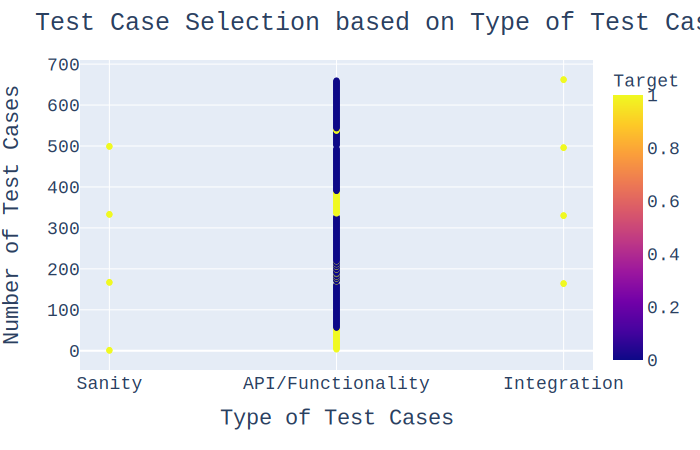

In [216]:
#Visualizing selection of test cases based on type of test cases
fig = px.scatter(dataset,y=dataset.index,x='Type of Test Case',color='Target')
# Change the bar mode
fig.update_layout(
    title="Test Case Selection based on Type of Test Cases",
    xaxis_title="Type of Test Cases",
    yaxis_title="Number of Test Cases",   
    font=dict(
        family="Courier New, monospace",
        size=18,
    )
)
fig.update_layout()
fig.show("svg")

All **Sanity** and **Integration** type of test cases are selected in all four release. With this we can conclude that **Type of Test Cases** are directly related to selection of test cases.

Now we will check **Automation Status** feature , will try to understand that how test cases are selected across releases based on automation status

**Total Number of Automated Test Cases are 236**

**Total number of selected test cases which are automated 139**

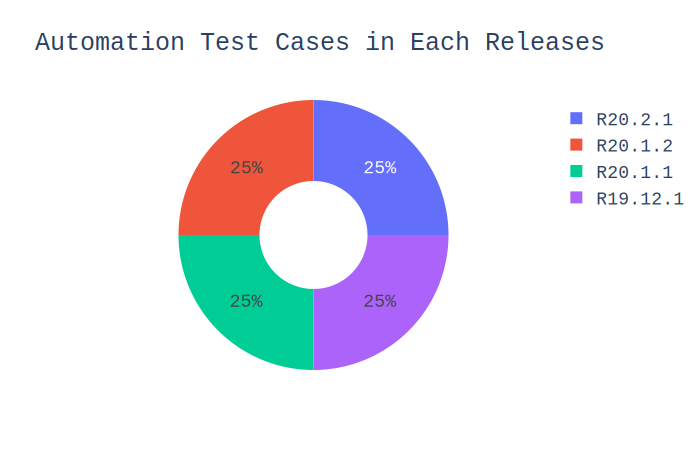

In [217]:
#Checking number of automated test cases, taking all Automtion selection test cases in seprate data frame df1
df1=dataset[dataset['Automation Status'] == 'Yes']
printmd("**Total Number of Automated Test Cases are {}**".format(len(df1.index)))
printmd("**Total number of selected test cases which are automated {}**".format(len(df1[df1['Target'] == 1].index)))

#Visualizing Number of Automated Test cases in each release
fig = go.Figure(data=[go.Pie(labels=df1['ReleaseID'],hole=.4)])
fig.update_layout(
    title="Automation Test Cases in Each Releases",
    font=dict(
        family="Courier New, monospace",
        size=18
    ))
fig.show("svg")


In our data set we have total **236** automated test cases and out of which **139** are selected test cases. Number of automated test cases are same in all four releases which is **59** .

Above data tell us that though number of automation test cases are same across all releases , selection of the same may depends upo other factors.

Let's find out more how many automated test cases are selected in different releases

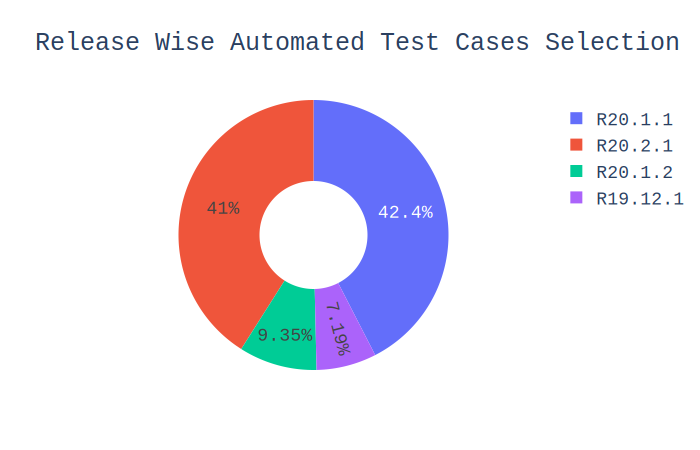

In [218]:
#Converting df1 data frame to only selected test cases
df1=dataset[(dataset['Automation Status'] == 'Yes') & (dataset['Target'] == 1)]
#Visualizing automted test cases selected per releases
fig = go.Figure(data=[go.Pie(labels=df1['ReleaseID'],hole=.4)])
fig.update_layout(
    title="Release Wise Automated Test Cases Selection",
    font=dict(
        family="Courier New, monospace",
        size=18
    ))
fig.show("svg")

Highest number of automated selected test cases i.e **42%** , **41%** are in **R20.1.1** and **R20.2.1** releases respectively and from our pevious analysis we can say that these are the two releases where we have maximum number of bugs and highest number selected test cases.

With this it's evident that **Automation Test Cases** feature played a role in test case selection specially when we have lot to test.

With this we are done with analysis of all categorical data columns present in our data set and all of them looks related to our Target Variable , we will keep all of them in our further analysis.

Let's start with Textual columns , we have following Text columns

<ol>
    <li><b>Test Case Title</b></li>
    <li><b>Test Case Description</b></li>
    <li><b>JIRA Bug ID</b></li>
    <li><b>Bug Description</b></li>
    <li><b>GIT Commit Message</b></li>
</ol>

From above features list we can remove 'JIRA Bug ID' from our analysis because this is just a alphanumeric respresentation of Bugs and more details are present in next feature 'Bug Description'. 

Also , in our data set 'GIT commit Message' is very inconsistent and most of the commit messages are of bug fixing and for these fixes commit messages are either bug ID or bug description which is kind of duplicate of data present in feature 'Bug Description'. We can drop  GIT commit message column also.

> **We recommend that 'Commit Messages' should be there for test cases selection but for this relevant and proper messages should enter at the time of commit and same has to be captured properly in Release Manifest for each releases**

Let's start looking at 'Test Case Title' and 'Test Case Description'

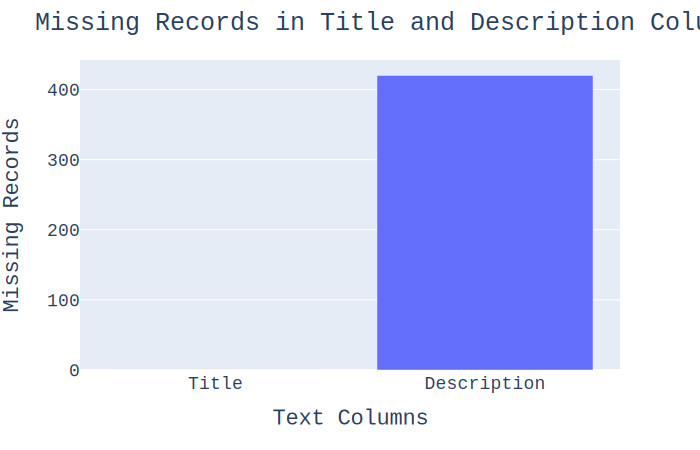

In [219]:
#Checking Null Values and creating bool series True for NaN values  
bool_series_title = pd.isnull(dataset["TestCaseTitle"])  
bool_series_description = pd.isnull(dataset["TestCaseDescription"])  

#Creating Data Dictonary for Missing Values
missingvalues_dict={'Title':len(dataset[bool_series_title].index),'Description':len(dataset[bool_series_description].index)}
#Converting Data Dictionary into Series
missingvalues_series=pd.Series(missingvalues_dict) 

#Visualizing missing values
fig = px.bar(missingvalues_series, y=missingvalues_series.values, x=missingvalues_series.index)
# Change the bar mode
fig.update_layout(
    title=" Missing Records in Title and Description Columns ",
    xaxis_title="Text Columns",
    yaxis_title="Missing Records",   
    font=dict(
        family="Courier New, monospace",
        size=18,
    )
)
fig.update_layout()
fig.show("svg")

There are no empty records in Test Case Title but same is not true for Description , majority of the description is empty. 

Moreover , if we take a closer look in Title then we can say that it consist of summary of a test case which itself is a good information to select or unselect the test case. With this information we can drop 'Test Case Description' from our list.

Our Textual feature list for analysis will be reduced to following

<ol>
    <li><b>Test Case Title</b></li>
    <li><b>Bug Description</b></li>
</ol>

'Test Case Title' should be primary entry point for test cases selection as it give summary/intention behind the test case and this makes perfect choice for Test Case Selection

We have already concluded that 'Any Defect' column has direct relation with test case selection and if 'Any Defect' column has a value then corresponding 'Bug Description' should be there. With this co relation we can say that this column should be there in our feature list but in our data set only few entries are there fo 'Bug Description' , so we can skip this column also from our list

In [220]:
printmd("**Number of records with bug descriptions are {}**".format(len(dataset[pd.notnull(dataset["Bug Description"])].index)))

**Number of records with bug descriptions are 21**

In [221]:
#Drop not required column
dataset=dataset.drop(['TestCaseDescription','GIT Commit Message','JIRA Bug ID','Bug Description'],axis=1)
dataset.head()

,Id,ReleaseID,Type of Test Case,TestCaseTitle,Error Prone Test Cases,Automation Status,Any Defect,Target
0,1,R20.2.1,Sanity,Get the short and detailed health status APIs,No,Yes,Yes,1
1,2,R20.2.1,Sanity,Get the AuthZ service metadata,No,Yes,Yes,1
2,3,R20.2.1,Sanity,Get the public keys for validating token,No,Yes,Yes,1
3,4,R20.2.1,API/Functionality,Verify Client delegation API: Exchange Access ...,Yes,Yes,No,1
4,5,R20.2.1,API/Functionality,Verify Client delegation API:Exchange Access t...,No,Yes,No,1


Now, we have **one** text column and **five** categorical columns and based on our analysis we can say that all of these are related to selection of test cases i.e. related to 'Target' variable. 

We can freeze above list of features for training classifier models , But before that we need to convert all categorical variables to **encoded variables** form and text columns into sparse matrix for features

In [222]:
#Encoding all categorical variable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
dataset['ReleaseID']=labelencoder.fit_transform(dataset['ReleaseID'])
dataset['Error Prone Test Cases']=labelencoder.fit_transform(dataset['Error Prone Test Cases'])
dataset['Type of Test Case']=labelencoder.fit_transform(dataset['Type of Test Case'])
dataset['Automation Status']=labelencoder.fit_transform(dataset['Automation Status'])
dataset['Any Defect']=labelencoder.fit_transform(dataset['Any Defect'])
dataset.head()

,Id,ReleaseID,Type of Test Case,TestCaseTitle,Error Prone Test Cases,Automation Status,Any Defect,Target
0,1,3,2,Get the short and detailed health status APIs,0,1,1,1
1,2,3,2,Get the AuthZ service metadata,0,1,1,1
2,3,3,2,Get the public keys for validating token,0,1,1,1
3,4,3,0,Verify Client delegation API: Exchange Access ...,1,1,0,1
4,5,3,0,Verify Client delegation API:Exchange Access t...,0,1,0,1


With this all categorical columns are encoded into numerical values. Now , let's deal with our only Text column i.e. 'TestCaseTitle'.

For this we will apply **Natural Language Processing** (NLP) to convert text data into features for classifier model

Let's create Corpus from 'TestCaseTitle' , **Corpus** is a simplified version of our test case title data that contain clean text data.

To create Corpus we have to perform the following actions

<ol>
    <li><b>Remove unwanted words</b>: Removal of unwanted words such as <a>special characters</a> and <a>numbers</a> to get only pure text. We will do it by specify our pattern using re library</li>
    <li><b>Transform words to lowercase</b>: Transform words to lowercase because upper and lower case have diffirent <a>ASCII</a> codes</li>
    <li><b>Remove stopwords</b>:Stop words are usually the most common words in a language and they will be irrelevant in determining the nature</li>
    <li><b>Stemming words</b>:Stemming is the process of reducing words to their word stem, base or root form. We use stemming to reduce Bag of Words dimensionality</li>
</ol>

In [197]:
#Importing required libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus_title = []
pstem = PorterStemmer()
for i in range(dataset['TestCaseTitle'].shape[0]):
    #Remove unwanted words
    text = re.sub("[^a-zA-Z]", ' ', dataset['TestCaseTitle'][i])
    #Transform words to lowercase
    text = text.lower()
    text = text.split()
    #Remove stopwords then Stemming it
    text = [pstem.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    #Append cleaned tweet to corpus
    corpus_title.append(text)
    
printmd("**Corpus created successfully**") 

**Corpus created successfully**

From above Corpus we will create **Bag of Words**  , which is representation of text that describes the occurrence of words within a document. It involves two things:

* A vocabulary of known words
* A measure of the presence of known words

This is called Bag of Word because any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document.

For Example : 

<img src="images/BagOfWord.png">



We can do this using scikit-learn's **CountVectorizer**, where every row will represent a different test case and every column will represent a different word.

Countvectorizer converts a collection of text documents to a matrix of token counts. It is important to note here that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal.However, i did all the process manually above to just get a better understanding. 

In [224]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
text_vectors= cv.fit_transform(corpus_title).toarray()

#Convert text vectors into data frame
text_vectors_df=pd.DataFrame(text_vectors)
printmd("**Dimension for Text features are {}**".format(text_vectors_df.shape))

**Dimension for Text features are (664, 115)**

In [199]:
#Getting Target variable into Y variable
y=dataset[['Target']].values
#Converting 2 dimensional y and y_pred array into single dimension
y=y.ravel()

#Removing 'Target' and 'TestCaseTitle' columns from actual dataset
dataset=dataset.drop(['Target','TestCaseTitle'],axis=1)

#Creating new data frame with all categorical feature and Text features for training classifier models
X=pd.concat([dataset,text_vectors_df],axis=1).values
printmd("**Dimension for features data frame are {}**".format(X.shape))
#X.head()

**Dimension for features data frame are (664, 121)**

With this we have completed our  EDA and Feature Engineering , let's start with classifier models creation

# Learning and Classification

Now we will build our models, for current data set we are using follwoing models

* Logistic Regression Model
* Gaussian Naive Bayes Model
* Multinomial Naive Bayes Model

If we have large data set we can use following models but for current data set we are avoiding them

* Decision Tree Model
* Gradient Boosting Model
* K - Nearest Neighbors Model

In [200]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Logistic Regression Model

In [201]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
classifier_lr = LogisticRegression(solver='liblinear')
classifier_lr.fit(X_train,y_train)
# Predicting the Test set results
y_pred_lr = classifier_lr.predict(X_test)
# Making the Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

## Gaussian Naive Bayes Model

In [202]:
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import f1_score

# Fitting Gausian to the Training set
classifier_gnb = GaussianNB()
classifier_gnb.fit(X_train, y_train)
# Predicting the Test set results
y_pred_gnb = classifier_gnb.predict(X_test)
# Making the Confusion Matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)

## Multinomial Naive Bayes Model

In [203]:
from sklearn.naive_bayes import MultinomialNB
# Fitting Naive Bayes to the Training set
classifier_nb = MultinomialNB(alpha=0.1)
classifier_nb.fit(X_train, y_train)
# Predicting the Test set results
y_pred_nb = classifier_gnb.predict(X_test)
# Making the Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

## Model Evaluation

We will evaluate model based on confusion matrix , which is formed from the four outcomes produced as a result of binary classification

A binary classifier predicts all data instances of a test dataset as either positive or negative. This classification (or prediction) produces four outcomes – true positive, true negative, false positive and false negative.

* True positive (TP): correct positive prediction
* False positive (FP): incorrect positive prediction
* True negative (TN): correct negative prediction
* False negative (FN): incorrect negative prediction

<img src="images/ConfusionMatrix.png">

## Confusion matrix
A confusion matrix of binary classification is a two by two table formed by counting of the number of the four outcomes of a binary classifier. We usually denote them as TP, FP, TN, and FN instead of “the number of true positives”, and so on

<img src="images/ConfusionMatrixTable.png">

## Error Rate

Error rate (ERR) is calculated as the number of all incorrect predictions divided by the total number of the dataset. The best error rate is 0.0, whereas the worst is 1.0

<img src="images/ErrorRate.png">

## Accuracy
Accuracy (ACC) is calculated as the number of all correct predictions divided by the total number of the dataset. The best accuracy is 1.0, whereas the worst is 0.0. It can also be calculated by 1 – ERR

<img src="images/AccuracyRate.png">

## F1 Score

<img src="images/F1Score.png">

In [204]:
#Calculating Model Accuracy
printmd('**Regression Classifier Accuracy Score is {} for Train Data Set**'.format(classifier_lr.score(X_train, y_train)))
printmd('**Regression Classifier Accuracy Score is {} for Test Data Set**'.format(classifier_lr.score(X_test, y_test)))
printmd('**Regression Classifier F1 Score is {}**'.format(f1_score(y_test, y_pred_lr)))
printmd('**Confusion Matrix for Regression Classifer {}**'.format(cm_lr))
printmd('**--------------------------------------------------------------------------------**')
printmd('**GaussianNB Classifier Accuracy Score is {} for Train Data Set**'.format(classifier_gnb.score(X_train, y_train)))
printmd('**GaussianNB Classifier Accuracy Score is {} for Test Data Set**'.format(classifier_gnb.score(X_test, y_test)))
printmd('**GaussianNB Classifier F1 Score is {}**'.format(f1_score(y_test, y_pred_gnb)))
printmd('**Confusion Matrix for GaussianNB Classifer {}**'.format(cm_gnb))
printmd('**--------------------------------------------------------------------------------**')
printmd('**MultinomialNB Classifier Accuracy Score is {} for Train Data Set**'.format(classifier_nb.score(X_train, y_train)))
printmd('**MultinomialNB Classifier Accuracy Score is {} for Test Data Set**'.format(classifier_nb.score(X_test, y_test)))
printmd('**MultinomialNB Classifier F1 Score is {}**'.format(f1_score(y_test, y_pred_nb)))
printmd('**Confusion Matrix for MultinomialNB Classifer {}**'.format(cm_nb))


**Regression Classifier Accuracy Score is 0.9020715630885122 for Train Data Set**

**Regression Classifier Accuracy Score is 0.8421052631578947 for Test Data Set**

**Regression Classifier F1 Score is 0.6865671641791046**

**Confusion Matrix for Regression Classifer [[89 10]
 [11 23]]**

**--------------------------------------------------------------------------------**

**GaussianNB Classifier Accuracy Score is 0.8041431261770244 for Train Data Set**

**GaussianNB Classifier Accuracy Score is 0.7819548872180451 for Test Data Set**

**GaussianNB Classifier F1 Score is 0.7010309278350516**

**Confusion Matrix for GaussianNB Classifer [[70 29]
 [ 0 34]]**

**--------------------------------------------------------------------------------**

**MultinomialNB Classifier Accuracy Score is 0.8757062146892656 for Train Data Set**

**MultinomialNB Classifier Accuracy Score is 0.8421052631578947 for Test Data Set**

**MultinomialNB Classifier F1 Score is 0.7010309278350516**

**Confusion Matrix for MultinomialNB Classifer [[70 29]
 [ 0 34]]**

# Last Word !!

* Prediction could be improved if we have large data set , becuase then we can apply models like **Decision Tree Model ,Gradient Boosting Model** and **K-Nearest Neighbors Model** . We have checked these models for larger data set and prediction was pretty good
* Training data can be increase by adding more releases data
* Above approach can be used as a reference for similar problem statement
> **To convert this code into utility for test case selection in upcoming releases , data has to be captured in above format i.e. all mentioned fetaures has to be there along with test cases**